In [9]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scipy.fft as fft
import scipy.signal as signal

## FFT

In [10]:
# Reload the data
data = pd.read_csv("../Data/center_sternum.txt", sep='\t')[1500:-2500].reset_index(drop=True)
data = data.drop(columns=["Log Mode","Log Freq", "Timestamp"])

# PCA
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)
pca = PCA()
new_data = pca.fit_transform(scaled_data)
data_pca = pd.DataFrame(new_data[:,0:7])

In [11]:
data.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagnX,MagnY,MagnZ,qw,qi,qj,qk
0,-24.949,115.046,-951.661,0.687023,4.870229,1.511450,-212,-434,435,0.019833,0.478469,-0.875698,-0.061861
1,-10.980,106.323,-971.059,1.358779,3.358779,1.099237,-212,-435,435,0.020230,0.478378,-0.875820,-0.060701
2,-17.690,109.800,-970.022,1.068702,3.160305,0.702290,-213,-435,434,0.019798,0.478317,-0.875912,-0.059999
3,-21.533,104.249,-965.630,0.687023,2.793893,0.381679,-213,-435,434,0.020242,0.478256,-0.876003,-0.058992
4,-23.668,104.737,-967.033,0.305343,2.748092,0.778626,-214,-435,435,0.020089,0.478225,-0.876064,-0.058382


In [12]:
N = len(data_pca)
acq_freq = 200

# Perform the DFT
sig_fft = fft.fftshift(fft.fft(data_pca, axis=0))
frequencies = fft.fftshift(fft.fftfreq(N, d=1/acq_freq))

(0.0, 1000.0)

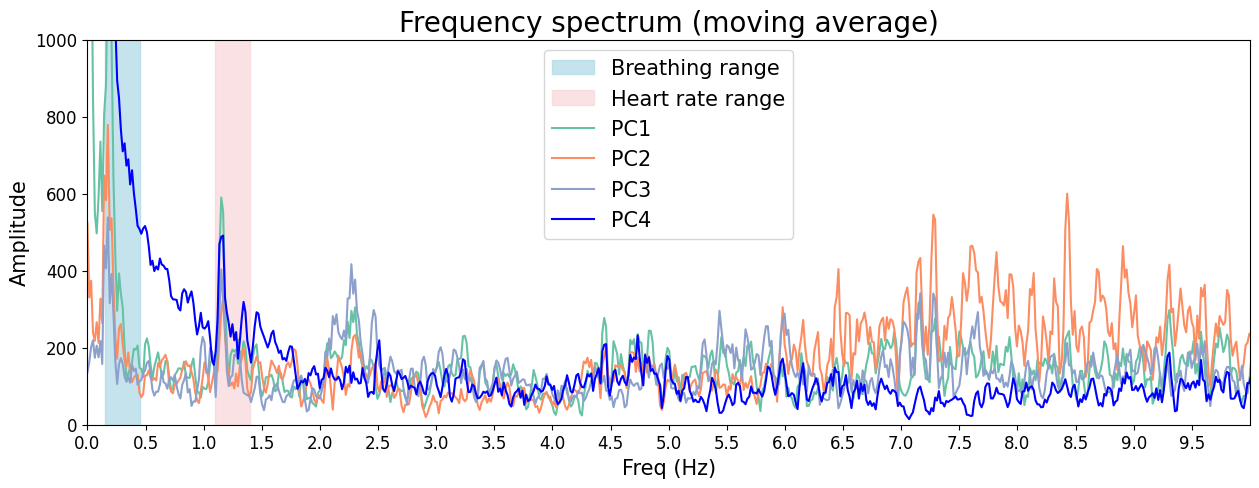

In [126]:
# Find the minima of the spectrum of the fourth principal component
minima, _ = signal.find_peaks(-np.abs(sig_fft[N//2:, 3]))


# Define the moving average (noise reduction)
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


# Plot the spectrum of the principal components
fig, ax = plt.subplots(figsize=(15, 5))

ax.axvspan(0.15, 0.45, color="lightblue", alpha=0.7, label="Breathing range")
ax.axvspan(1.1, 1.4, color="#F8D5D8", alpha=0.7, label="Heart rate range")

pca_indeces = [0, 1, 2, 3]
palette = ['#66c2a5', '#fc8d62', '#8da0cb', 'blue']
assert len(pca_indeces) == len(palette), "Size error"
for i, color in zip(pca_indeces, palette):
    ax.plot(frequencies[1:-1], moving_average(np.abs(sig_fft[:, i]), 3), color=color, label="PC"+str(i+1))

ax.set_xlim(0, 10)
ax.xaxis.set_ticks(np.arange(0, 10, 0.5))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("Freq (Hz)", fontsize=15)
ax.set_ylabel("Amplitude", fontsize=15)
ax.set_title("Frequency spectrum (moving average)", fontsize=20)
ax.legend(fontsize=15)
#ax.grid('lightgrey')

ax.set_ylim(0, 1000)


## 

In [134]:
# OLD VERSION
# Isolate the peak of interest
#sig_fft_peak = sig_fft[1.1 : 1.4]
sig_fft[frequencies < 1.1] = 0
sig_fft[frequencies > 1.3] = 0

f = frequencies[N//2 + minima[1] : N//2 + minima[4]]

# Antitrasform the data
data_peak = np.fft.ifft(np.fft.ifftshift(sig_fft), axis=0)

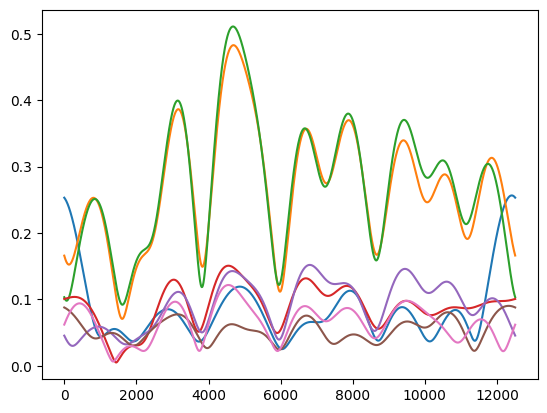

In [135]:
plt.plot(np.abs(data_peak))

In [91]:
mean_frequency = 200

In [16]:
import pywt
#pip install PyWavelets

In [85]:
pca_data = data_pca

In [20]:
pca4 = data_pca[3]

* $f_s$ is the sample frequency
* The Daubechies 6 wavelet: smooth and pattern similar to ours  
* level (:= J) refers to the number of iterations of splitting into low and high frequency: len(coeffs) = J + 1
* The result of the wavedec is a list
    * The first element is approximation coefficients array (it refers to frequencies from 0 to $f_s/2^{J+1}$)
    * The others are the details coefficients  $cD_j \in \{cD_J, ..., cD_1\}$ arrays (the $j$-th coefficient refers to the frequencies from $f_s/2^{j+1}$ to $f_s/2^{j}$)


In [114]:
# Perform the multilevel decomposition of the time series
max_level = pywt.dwt_max_level(len(pca_data), "db6")
print("Maximum useful level of decomposition for this dataset: " + str(max_level))

coeffs = pywt.wavedec(pca_data, "db6", level=max_level, axis=0)

Maximum useful level of decomposition for this dataset: 10


In [122]:
# Helper function to compute the frequency ranges of a wavelet decomposition
def get_frequency_ranges(f_s, level):
    freq = [[0, f_s/2**(level+1)]]

    for j in range(level, 0, -1):
        freq.append([f_s/2**(j+1), f_s/2**(j)])

    return freq

get_frequency_ranges(mean_frequency, max_level)

[[0, 0.09765625],
 [0.09765625, 0.1953125],
 [0.1953125, 0.390625],
 [0.390625, 0.78125],
 [0.78125, 1.5625],
 [1.5625, 3.125],
 [3.125, 6.25],
 [6.25, 12.5],
 [12.5, 25.0],
 [25.0, 50.0],
 [50.0, 100.0]]

We expect the normal beat to be between $[0.67, 1.67] Hz$. The coefficient we need is the fifth (frequences between $[0.78, 1.56]Hz$). We are cutting some boundary frequences.  

In [116]:
# Function to set to zero the unwanted coefficients
def select_coeffs(coeffs, useful_coeffs):
    assert type([0, 1]) == list, "useful_coeffs must be a list"

    for i in range(len(coeffs)):
        if i not in useful_coeffs:
            #Replace with a zero array of the same size
            coeffs[i] = np.zeros_like(coeffs[i])
    
    return coeffs

filtered_coeff = select_coeffs(coeffs, [4])

In [117]:
filtered_sig = pywt.waverec(filtered_coeff, "db6", axis=0)

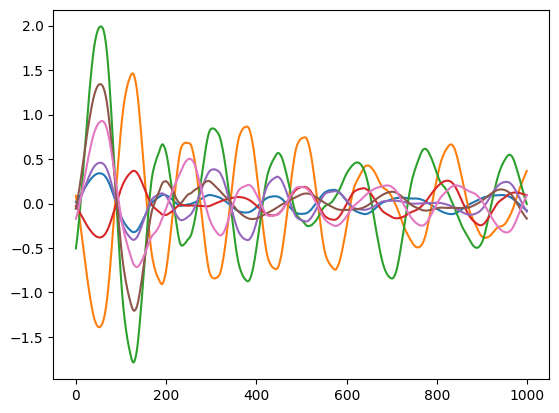

In [118]:
plt.plot(filtered_sig[:1000])